In [1]:
DEBUG = False

In [2]:
# pip install timm

In [3]:
# !pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

In [4]:
# !pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu102/torch_nightly.html

In [5]:
import os
import sys
# sys.path = [
#     '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master',
# ] + sys.path

In [6]:
import time
import skimage.io
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from  torch.cuda.amp import GradScaler
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
import timm
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm_notebook as tqdm

# Config

In [7]:
data_dir = './data/'
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
image_folder = os.path.join(data_dir, 'train_images')

kernel_type = 'mixnet_l'

# enet_type = 'efficientnet-b2'
fold = 0
tile_size = 256
image_size = 256
n_tiles = 36
batch_size = 2
num_workers = 4
out_dim = 5
init_lr = 3e-4
warmup_factor = 10

warmup_epo = 1
n_epochs = 35 #1 if DEBUG else 30
df_train = df_train.sample(100).reset_index(drop=True) if DEBUG else df_train

device = torch.device('cuda')

print(image_folder)

./data/train_images


# Create Folds

In [8]:
# skf = StratifiedKFold(5, shuffle=True, random_state = 42)
# df_train['fold'] = -1
# for i, (train_idx, valid_idx) in enumerate(skf.split(df_train, df_train['isup_grade'])):
#     df_train.loc[valid_idx, 'fold'] = i
# df_train.head()

In [9]:
# df_train.to_csv('fold.csv', index = False)

In [10]:
df_train = pd.read_csv('fold.csv', index_col = False)
df_train = df_train.sample(100).reset_index(drop=True) if DEBUG else df_train

In [11]:
df_train.head()

,Unnamed: 0,image_id,data_provider,isup_grade,gleason_score,fold
0,0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,4
1,1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0
2,2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,3
3,3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,4
4,4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,4


# Model

In [12]:
from torch.nn.parameter import Parameter
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)       
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

    
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = backbone
        self.myfc = nn.Linear(self.enet.classifier.in_features, out_dim)
        self.enet.classifier = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x

# Dataset

In [13]:
def get_tiles(img, mode=0):
        result = []
        h, w, c = img.shape
        pad_h = (tile_size - h % tile_size) % tile_size + ((tile_size * mode) // 2)
        pad_w = (tile_size - w % tile_size) % tile_size + ((tile_size * mode) // 2)

        img2 = np.pad(img,[[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2,pad_w - pad_w//2], [0,0]], constant_values=255)
        img3 = img2.reshape(
            img2.shape[0] // tile_size,
            tile_size,
            img2.shape[1] // tile_size,
            tile_size,
            3
        )

        img3 = img3.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size,3)
        n_tiles_with_info = (img3.reshape(img3.shape[0],-1).sum(1) < tile_size ** 2 * 3 * 255).sum()
        if len(img3) < n_tiles:
            img3 = np.pad(img3,[[0,n_tiles-len(img3)],[0,0],[0,0],[0,0]], constant_values=255)
        idxs = np.argsort(img3.reshape(img3.shape[0],-1).sum(-1))[:n_tiles]
        img3 = img3[idxs]
        for i in range(len(img3)):
            result.append({'img':img3[i], 'idx':i})
        return result, n_tiles_with_info >= n_tiles


class PANDADataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 n_tiles=n_tiles,
                 tile_mode=0,
                 rand=False,
                 transform=None,
                ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.tile_mode = tile_mode
        self.rand = rand
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        tiff_file = os.path.join(image_folder, f'{img_id}.tiff')
        image = skimage.io.MultiImage(tiff_file)[1]
        tiles, OK = get_tiles(image, self.tile_mode)

        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))

        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
    
                if len(tiles) > idxes[i]:
                    this_img = tiles[idxes[i]]['img']
                else:
                    this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                images[h1:h1+image_size, w1:w1+image_size] = this_img

        if self.transform is not None:
            images = self.transform(image=images)['image']
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)

        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        return torch.tensor(images), torch.tensor(label)


# Augmentations

In [14]:
transforms_train = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
])
transforms_val = albumentations.Compose([])

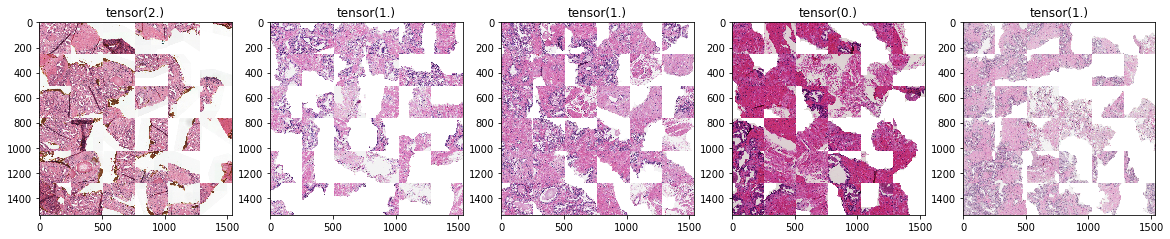

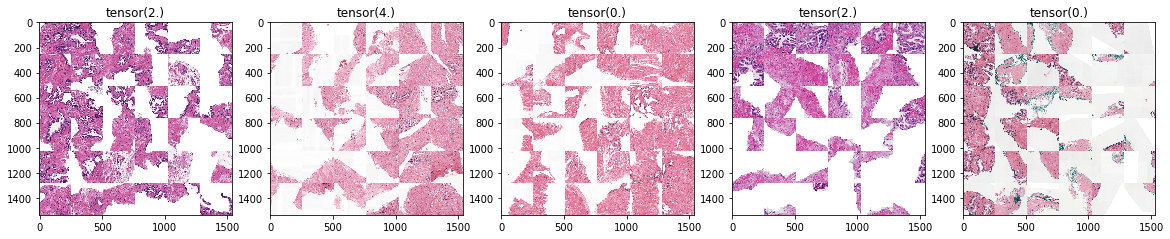

In [15]:
dataset_show = PANDADataset(df_train, image_size, n_tiles, 0, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(sum(label)))


# Loss

In [16]:
criterion = nn.BCEWithLogitsLoss()

# Train & Val

In [17]:
def train_epoch(loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        
        data, target = data.to(device), target.to(device)
        loss_func = criterion
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            logits = model(data)
            loss = loss_func(logits, target)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        
        scaler.update()
        
        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def val_epoch(loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)

            loss = criterion(logits, target)

            pred = logits.sigmoid().sum(1).detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target.sum(1))

            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    acc = (PREDS == TARGETS).mean() * 100.
    
    qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')
    qwk_k = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'karolinska'], df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values, weights='quadratic')
    qwk_r = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'radboud'], df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values, weights='quadratic')
    print('qwk', qwk, 'qwk_k', qwk_k, 'qwk_r', qwk_r)

    if get_output:
        return LOGITS
    else:
        return val_loss, acc, qwk

    

# Create Dataloader & Model & Optimizer

In [18]:
train_idx = np.where((df_train['fold'] != fold))[0]
valid_idx = np.where((df_train['fold'] == fold))[0]

df_this  = df_train.loc[train_idx]
df_valid = df_train.loc[valid_idx]

dataset_train = PANDADataset(df_this , image_size, n_tiles, transform=transforms_train)
dataset_valid = PANDADataset(df_valid, image_size, n_tiles, transform=transforms_val)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=num_workers)


model = timm.create_model('mixnet_l', pretrained=True)

enet_type = model
model = enetv2(enet_type, out_dim=out_dim)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=init_lr/warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-warmup_epo)
scheduler = GradualWarmupScheduler(optimizer, multiplier=warmup_factor, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

print(len(dataset_train), len(dataset_valid))

8492 2124


In [19]:
model.avg_pool = GeM()
model

enetv2(
  (enet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv_pw): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
        )
      )
      (1): Sequential(
        (0): InvertedResidual(
          (conv_pw): MixedConv2d(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): Conv2d(16, 

# Run Training

In [ ]:
%%time

qwk_max = 0.
best_file = f'./ckpts/{kernel_type}_best_fold{fold}.pth'

scaler = GradScaler()

for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    scheduler.step(epoch-1)

    train_loss = train_epoch(train_loader, optimizer)
    val_loss, acc, qwk = val_epoch(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}, qwk: {(qwk):.5f}'
    print(content)
    with open(f'./logs/log_{kernel_type}.txt', 'a') as appender:
        appender.write(content + '\n')

    if qwk > qwk_max:
        print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(qwk_max, qwk))
        torch.save(model.state_dict(), best_file)
        qwk_max = qwk

torch.save(model.state_dict(), os.path.join(f'./ckpts/{kernel_type}_final_fold{fold}.pth'))

Mon Jun 29 22:14:36 2020 Epoch: 1


/home/tonychenxyz/anaconda3/envs/torch1.6/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/home/tonychenxyz/anaconda3/envs/torch1.6/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an i


qwk 0.7479654428818285 qwk_k 0.731307217940802 qwk_r 0.6853809641569628
Mon Jun 29 22:50:12 2020 Epoch 1, lr: 0.0000300, train loss: 0.43594, val loss: 0.31418, acc: 38.74765, qwk: 0.74797
score2 (0.000000 --> 0.747965).  Saving model ...
Mon Jun 29 22:50:12 2020 Epoch: 2



qwk 0.7378480155041203 qwk_k 0.6991873693436536 qwk_r 0.6680865655048986
Mon Jun 29 23:25:40 2020 Epoch 2, lr: 0.0003000, train loss: 0.36100, val loss: 0.33527, acc: 46.37476, qwk: 0.73785
Mon Jun 29 23:25:40 2020 Epoch: 3



qwk 0.8381453404165317 qwk_k 0.844604866408919 qwk_r 0.7883064029985506
Tue Jun 30 00:01:09 2020 Epoch 3, lr: 0.0000300, train loss: 0.26513, val loss: 0.25591, acc: 57.72128, qwk: 0.83815
score2 (0.747965 --> 0.838145).  Saving model ...
Tue Jun 30 00:01:09 2020 Epoch: 4



qwk 0.7729090082704309 qwk_k 0.804417755664895 qwk_r 0.6999221721263988
Tue Jun 30 00:36:21 2020 Epoch 4, lr: 0.0002974, train loss: 0.29167, val loss: 0.30022, acc: 53.24859, qwk: 0.77291
Tue Jun 30 00:36:21 2020 Epoch: 5



qwk 0.8424989715826152 qwk_k 0.8570630152298448 qwk_r 0.7772112583837689
Tue Jun 30 01:11:51 2020 Epoch 5, lr: 0.0002943, train loss: 0.26956, val loss: 0.23930, acc: 57.01507, qwk: 0.84250
score2 (0.838145 --> 0.842499).  Saving model ...
Tue Jun 30 01:11:51 2020 Epoch: 6



qwk 0.834691803303959 qwk_k 0.8521093638080491 qwk_r 0.7654031260372348
Tue Jun 30 01:47:21 2020 Epoch 6, lr: 0.0002899, train loss: 0.25126, val loss: 0.23964, acc: 56.16761, qwk: 0.83469
Tue Jun 30 01:47:21 2020 Epoch: 7



qwk 0.8389048223443949 qwk_k 0.8586740728858693 qwk_r 0.7796730009995326
Tue Jun 30 02:22:31 2020 Epoch 7, lr: 0.0002843, train loss: 0.23769, val loss: 0.24668, acc: 56.77966, qwk: 0.83890
Tue Jun 30 02:22:31 2020 Epoch: 8



qwk 0.8300243067937334 qwk_k 0.8441794329591915 qwk_r 0.76189360517704
Tue Jun 30 02:57:42 2020 Epoch 8, lr: 0.0002775, train loss: 0.22875, val loss: 0.26518, acc: 53.57815, qwk: 0.83002
Tue Jun 30 02:57:42 2020 Epoch: 9



qwk 0.8254456192334164 qwk_k 0.8560062312195171 qwk_r 0.759755683686791
Tue Jun 30 03:32:53 2020 Epoch 9, lr: 0.0002697, train loss: 0.22046, val loss: 0.28139, acc: 61.25235, qwk: 0.82545
Tue Jun 30 03:32:53 2020 Epoch: 10



qwk 0.8474629617139903 qwk_k 0.8612028162837723 qwk_r 0.792279117192191
Tue Jun 30 04:08:05 2020 Epoch 10, lr: 0.0002609, train loss: 0.21172, val loss: 0.24703, acc: 60.82863, qwk: 0.84746
score2 (0.842499 --> 0.847463).  Saving model ...
Tue Jun 30 04:08:05 2020 Epoch: 11



qwk 0.8588058335398449 qwk_k 0.8849555016410312 qwk_r 0.7977773967894487
Tue Jun 30 04:43:16 2020 Epoch 11, lr: 0.0002511, train loss: 0.20317, val loss: 0.24267, acc: 60.78154, qwk: 0.85881
score2 (0.847463 --> 0.858806).  Saving model ...
Tue Jun 30 04:43:16 2020 Epoch: 12



qwk 0.8410373954609763 qwk_k 0.8809177631282886 qwk_r 0.7706232392764029
Tue Jun 30 05:18:26 2020 Epoch 12, lr: 0.0002404, train loss: 0.19200, val loss: 0.26606, acc: 61.62900, qwk: 0.84104
Tue Jun 30 05:18:26 2020 Epoch: 13



qwk 0.854693467867614 qwk_k 0.8786489245601948 qwk_r 0.7924753588841077
Tue Jun 30 05:53:37 2020 Epoch 13, lr: 0.0002290, train loss: 0.18812, val loss: 0.26939, acc: 61.77024, qwk: 0.85469
Tue Jun 30 05:53:37 2020 Epoch: 14



qwk 0.8482106059387629 qwk_k 0.8681731995148643 qwk_r 0.791861614409033
Tue Jun 30 06:28:49 2020 Epoch 14, lr: 0.0002169, train loss: 0.18310, val loss: 0.27322, acc: 64.78343, qwk: 0.84821
Tue Jun 30 06:28:49 2020 Epoch: 15



qwk 0.8470767546104307 qwk_k 0.8829828605940974 qwk_r 0.7783988146970721
Tue Jun 30 07:04:00 2020 Epoch 15, lr: 0.0002042, train loss: 0.17270, val loss: 0.28776, acc: 62.52354, qwk: 0.84708
Tue Jun 30 07:04:00 2020 Epoch: 16



qwk 0.846742383197209 qwk_k 0.8691904226599798 qwk_r 0.7906410913185701
Tue Jun 30 07:39:11 2020 Epoch 16, lr: 0.0001910, train loss: 0.16859, val loss: 0.26220, acc: 64.03013, qwk: 0.84674
Tue Jun 30 07:39:11 2020 Epoch: 17



qwk 0.8539117850093573 qwk_k 0.8802957964387762 qwk_r 0.7951144630181024
Tue Jun 30 08:14:22 2020 Epoch 17, lr: 0.0001776, train loss: 0.15881, val loss: 0.27315, acc: 63.46516, qwk: 0.85391
Tue Jun 30 08:14:22 2020 Epoch: 18



qwk 0.826052851725015 qwk_k 0.8902504797062007 qwk_r 0.7055572375084778
Tue Jun 30 08:49:45 2020 Epoch 18, lr: 0.0001638, train loss: 0.15227, val loss: 0.27347, acc: 61.86441, qwk: 0.82605
Tue Jun 30 08:49:45 2020 Epoch: 19



qwk 0.8678729272325421 qwk_k 0.8859926431881524 qwk_r 0.8160761021777971
Tue Jun 30 09:24:58 2020 Epoch 19, lr: 0.0001500, train loss: 0.14612, val loss: 0.26257, acc: 64.83051, qwk: 0.86787
score2 (0.858806 --> 0.867873).  Saving model ...
Tue Jun 30 09:24:58 2020 Epoch: 20



qwk 0.8581026913533117 qwk_k 0.8792873336117708 qwk_r 0.80745400001179
Tue Jun 30 10:00:10 2020 Epoch 20, lr: 0.0001362, train loss: 0.13854, val loss: 0.28590, acc: 66.71375, qwk: 0.85810
Tue Jun 30 10:00:10 2020 Epoch: 21



qwk 0.8539506914138336 qwk_k 0.881244144304641 qwk_r 0.7901901245728307
Tue Jun 30 10:35:23 2020 Epoch 21, lr: 0.0001224, train loss: 0.13039, val loss: 0.30188, acc: 62.57062, qwk: 0.85395
Tue Jun 30 10:35:23 2020 Epoch: 22



qwk 0.8589988895231209 qwk_k 0.8820342680060993 qwk_r 0.8025650401761201
Tue Jun 30 11:10:35 2020 Epoch 22, lr: 0.0001090, train loss: 0.12188, val loss: 0.30306, acc: 64.03013, qwk: 0.85900
Tue Jun 30 11:10:35 2020 Epoch: 23



qwk 0.8535038010454284 qwk_k 0.883140598769248 qwk_r 0.7888214226477932
Tue Jun 30 11:45:53 2020 Epoch 23, lr: 0.0000958, train loss: 0.11669, val loss: 0.31669, acc: 66.57250, qwk: 0.85350
Tue Jun 30 11:45:53 2020 Epoch: 24
